In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [5]:
!unzip PageSegData

Archive:  PageSegData.zip
  inflating: PageSegData/PageImg/1.JPG  
  inflating: PageSegData/PageImg/10.JPG  
  inflating: PageSegData/PageImg/100.JPG  
  inflating: PageSegData/PageImg/101.JPG  
  inflating: PageSegData/PageImg/102.JPG  
  inflating: PageSegData/PageImg/103.JPG  
  inflating: PageSegData/PageImg/104.JPG  
  inflating: PageSegData/PageImg/105.JPG  
  inflating: PageSegData/PageImg/106.JPG  
  inflating: PageSegData/PageImg/107.JPG  
  inflating: PageSegData/PageImg/108.JPG  
  inflating: PageSegData/PageImg/109.JPG  
  inflating: PageSegData/PageImg/11.JPG  
  inflating: PageSegData/PageImg/110.JPG  
  inflating: PageSegData/PageImg/111.JPG  
  inflating: PageSegData/PageImg/112.JPG  
  inflating: PageSegData/PageImg/113.JPG  
  inflating: PageSegData/PageImg/114.JPG  
  inflating: PageSegData/PageImg/115.JPG  
  inflating: PageSegData/PageImg/116.JPG  
  inflating: PageSegData/PageImg/117.JPG  
  inflating: PageSegData/PageImg/118.JPG  
  inflating: PageSegData/PageImg

In [31]:
#Importing required libraries.
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
import random

image_list=os.listdir('/content/drive/MyDrive/Colab Notebooks/PageSegData/PageImg/')
image_list=[filename.split(".")[0]for filename in image_list]

def visualize(img,seg_img):
    """
    Visualizes image
    """
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('Image')
    plt.subplot(1,2,2)
    plt.imshow(seg_img,cmap='gray')
    plt.title('Segmented Image')
    plt.show()

def get_segmented_img(img,n_classes):
    """
    Loads in the segmented image and create suitable segmentation label.
    """
    seg_labels=np.zeros((512,512,1))
    # img=cv2.resize(img,(1024,1024))
    img=cv2.resize(img,(512,512))

    img=img[:,:,0]
    cl_list=[0,24]


    seg_labels[:,:,0]=(img!=0).astype(int)


    return seg_labels
def preprocess_img(img):
    # img=cv2.resize(img,(1024,1024))
    img=cv2.resize(img,(512,512))

    return img

def batch_generator(filelist,n_classes,batch_size):
  while True:
    X=[]
    Y=[]
    for i in range(batch_size):
      fn=random.choice(filelist)
      img_path = f'/content/drive/MyDrive/Colab Notebooks/PageSegData/PageImg/{fn}.JPG'
      # print(f"Loading image from: {img_path}")

      img = cv2.imread(img_path, 0)
      if img is None:
        print(f"Error: Image {img_path} not found or cannot be read.")
        continue;
      # img=cv2.imread(f'/content/drive/MyDrive/Colab Notebooks/PageSegData/PageImg/{fn}.JPG',0)
      ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
      # img=cv2.resize(img,(1024,1024))
      img=cv2.resize(img,(512,512))

      img=np.expand_dims(img,axis=-1)
      img = np.repeat(img, 3, axis=-1)
      #img = np.stack((img,)*3, axis=-1)
      img=img/255

      seg=cv2.imread(f'/content/drive/MyDrive/Colab Notebooks/PageSegData/PageSeg/{fn}_mask.png',1)
      seg=get_segmented_img(seg,n_classes)

      X.append(img)
      Y.append(seg)
    yield np.array(X),np.array(Y)

In [4]:
len(image_list)


300

Checking the loaded dataset



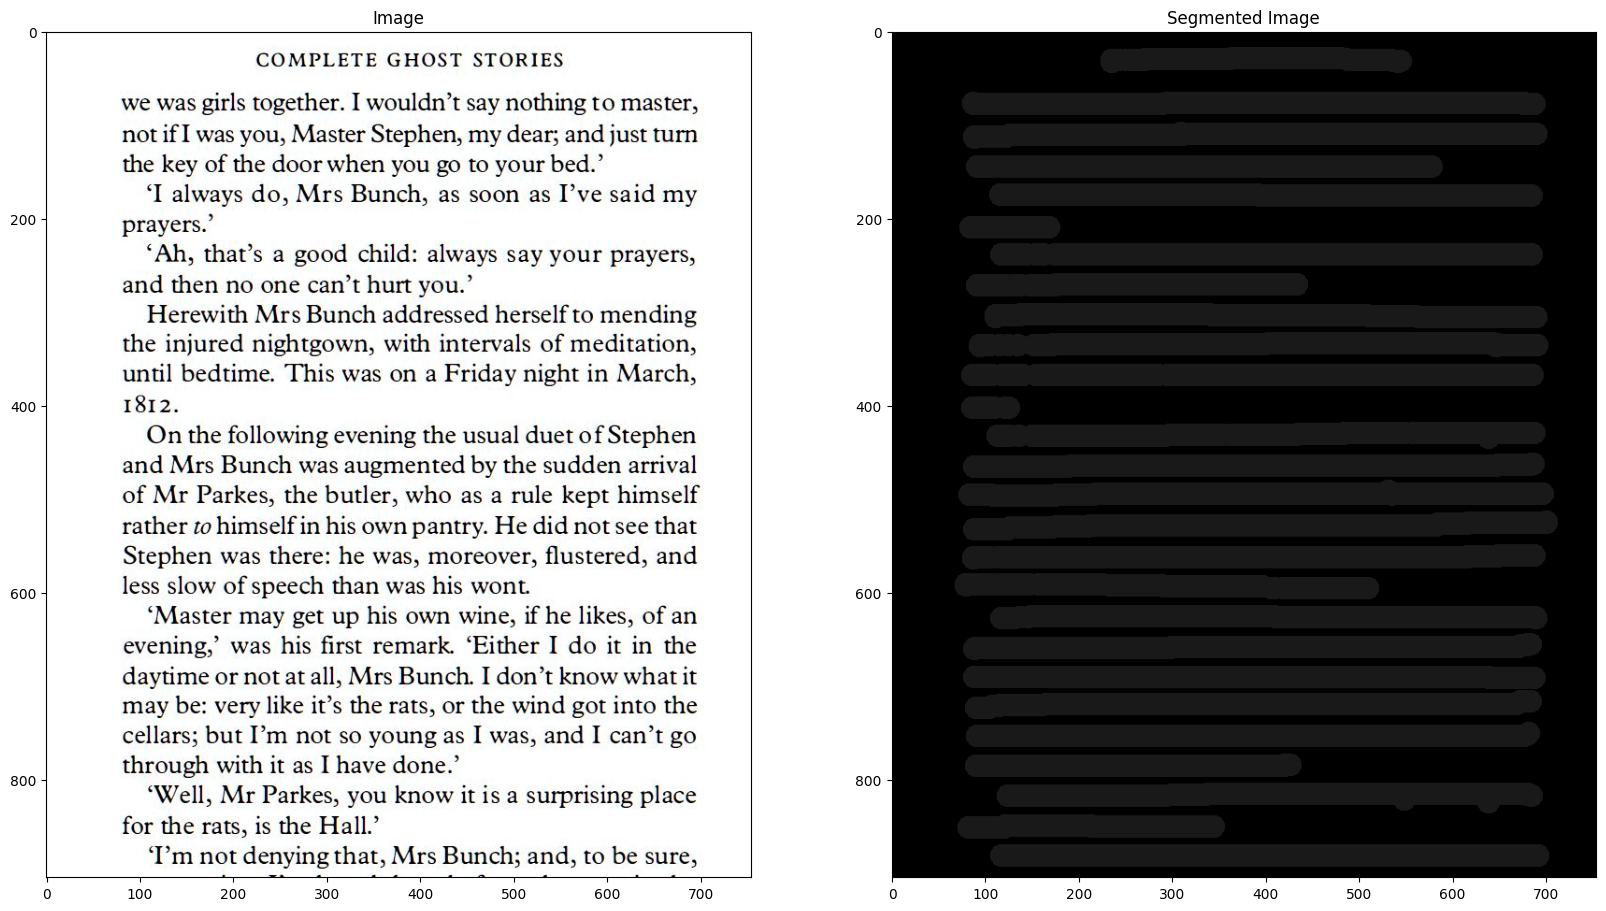

In [5]:
img=cv2.imread('/content/drive/MyDrive/Colab Notebooks/PageSegData/PageImg/'+image_list[5]+'.JPG',1)
seg=cv2.imread('/content/drive/MyDrive/Colab Notebooks/PageSegData/PageSeg/'+image_list[5]+'_mask.png',1)

visualize(img,seg)


In [35]:
# def unet(pretrained_weights = None,input_size = (512,512,1)):
#     inputs = Input(input_size)
#     conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
#     conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
#     conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
#     conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
#     conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
#     conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
#     conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
#     conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
#     drop4 = Dropout(0.5)(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

#     conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
#     conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
#     drop5 = Dropout(0.5)(conv5)

#     up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
#     merge6 = concatenate([drop4,up6], axis = 3)
#     conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
#     conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

#     up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
#     merge7 = concatenate([conv3,up7], axis = 3)
#     conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
#     conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

#     up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
#     merge8 = concatenate([conv2,up8], axis = 3)
#     conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
#     conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

#     up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
#     merge9 = concatenate([conv1,up9], axis = 3)
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
#     conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
#     conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

#     model = Model(inputs,conv10)

#     model.compile(optimizer = Adam(learning_rate=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
#     # model.compile(optimizer='adam', loss=combined_loss, metrics=['accuracy'])

#     model.summary()

#     if(pretrained_weights):
#     	model.load_weights(pretrained_weights)

#     return model

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Activation, BatchNormalization, Multiply, Add

# Attention Block
def attention_gate(x, g, inter_channels):
    """
    x: Skip connection from encoder
    g: Decoder features
    inter_channels: Intermediate channel size for attention computation
    """
    theta_x = Conv2D(inter_channels, (1,1), strides=(1,1), padding='same')(x)  # Transform encoder features
    phi_g = Conv2D(inter_channels, (1,1), strides=(1,1), padding='same')(g)  # Transform decoder features

    add_xg = Add()([theta_x, phi_g])
    act_xg = Activation('relu')(add_xg)

    psi = Conv2D(1, (1,1), strides=(1,1), padding='same')(act_xg)
    psi = Activation('sigmoid')(psi)  # Generate attention map

    x = Multiply()([x, psi])  # Apply attention to skip connection
    return x

# U-Net with Attention
def attention_unet(input_shape=(512, 512, 3), num_classes=1):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = UpSampling2D((2, 2))(c4)
    att5 = attention_gate(c3, u5, 256)  # Apply attention to skip connection
    u5 = Concatenate()([u5, att5])

    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    att6 = attention_gate(c2, u6, 128)
    u6 = Concatenate()([u6, att6])

    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    att7 = attention_gate(c1, u7, 64)
    u7 = Concatenate()([u7, att7])

    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c7)  # Binary segmentation

    model = tf.keras.models.Model(inputs, outputs)
    return model

# Instantiate and compile the model
model = attention_unet(input_shape=(512, 512, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 512, 512, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 512, 512, 64)   │          1,792 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 512, 512, 64)   │         36,928 │ conv2d_96[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 256, 256, 64)   │              0 │ conv2d_97[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)        │ (None, 256, 256, 128)  │         73,856 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_99 (Conv2D)        │ (None, 256, 256, 128)  │        147,584 │ conv2d_98[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 128, 128, 128)  │              0 │ conv2d_99[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_100 (Conv2D)       │ (None, 128, 128, 256)  │        295,168 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_101 (Conv2D)       │ (None, 128, 128, 256)  │        590,080 │ conv2d_100[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 64, 64, 256)    │              0 │ conv2d_101[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_102 (Conv2D)       │ (None, 64, 64, 512)    │      1,180,160 │ max_pooling2d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_103 (Conv2D)       │ (None, 64, 64, 512)    │      2,359,808 │ conv2d_102[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_13          │ (None, 128, 128, 512)  │              0 │ conv2d_103[0][0]       │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_104 (Conv2D)       │ (None, 128, 128, 256)  │         65,792 │ conv2d_101[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_105 (Conv2D)       │ (None, 128, 128, 256)  │        131,328 │ up_sampling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 128, 128, 256)  │              0 │ conv2d_104[0][0],      │
│                           │                        │                │ conv2d_105[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18        

 Total params: 8,042,308 (30.68 MB)

 Trainable params: 8,042,308 (30.68 MB)

 Non-trainable params: 0 (0.00 B)

75% Train<br>
25% Test<br>
Randomly shuffled

In [28]:
random.shuffle(image_list)
file_train=image_list[0:int(0.75*len(image_list))]
file_test=image_list[int(0.75*len(image_list)):]

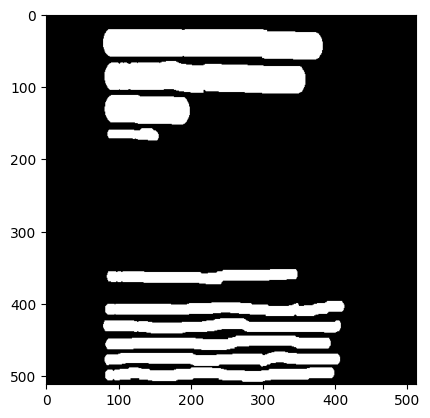

In [29]:
img,seg=next(batch_generator(file_train,2,1))
plt.imshow(np.squeeze(seg[:,:,:,0],axis=0),cmap='gray')

In [25]:

from tensorflow.keras import backend as K
def dice_loss(y_true, y_pred):
    smooth = 1.0
    intersection = K.sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

def weighted_cross_entropy(beta):
    def loss(y_true, y_pred):
        return -beta * y_true * K.log(y_pred + 1e-7) - (1 - beta) * (1 - y_true) * K.log(1 - y_pred + 1e-7)
    return loss

def combined_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + weighted_cross_entropy(0.7)(y_true, y_pred)

In [ ]:
#Model initialisation
# model = unet(pretrained_weights=False)

In [10]:
import os
import datetime
import tensorflow as tf



In [46]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/saved_models/attention/model_weights.h5')

In [42]:
# Generate a unique directory name based on timestamp
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
save_dir = os.path.join("saved_models", timestamp)

# Create the directory
os.makedirs(save_dir, exist_ok=True)

from keras.callbacks import ModelCheckpoint

# Define ModelCheckpoint callback
mc = ModelCheckpoint(
    filepath=os.path.join(save_dir, "model_weights.h5"),  # Updated file path pattern
    save_best_only=True,
     monitor='val_loss',
    mode='min'
)


# Use fit method with generator
model.fit(
    batch_generator(file_train, 2, 2),
    epochs=3,
    steps_per_epoch=len(file_train) // 2,
    validation_data=batch_generator(file_test, 2, 2),
    validation_steps=len(file_test) // 2,
    callbacks=[mc],
    shuffle=True  # Use boolean True instead of 1 for clarity
)

Epoch 1/3
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.9254 - loss: 0.1768

112/112 ━━━━━━━━━━━━━━━━━━━━ 50s 446ms/step - accuracy: 0.9254 - loss: 0.1768 - val_accuracy: 0.9297 - val_loss: 0.1634
Epoch 2/3
112/112 ━━━━━━━━━━━━━━━━━━━━ 50s 450ms/step - accuracy: 0.9319 - loss: 0.1634 - val_accuracy: 0.9146 - val_loss: 0.2068
Epoch 3/3
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9222 - loss: 0.1879

112/112 ━━━━━━━━━━━━━━━━━━━━ 52s 464ms/step - accuracy: 0.9222 - loss: 0.1878 - val_accuracy: 0.9349 - val_loss: 0.1597


Checking the model on untrained images

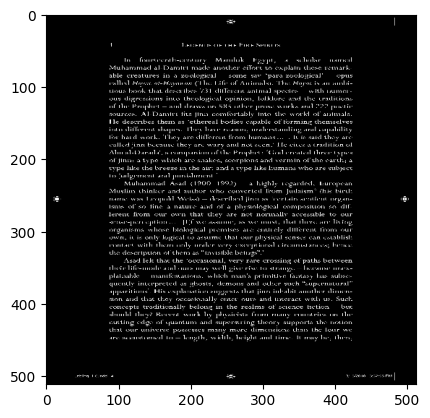

In [50]:
import seaborn as sns
img=cv2.imread('page_23.png',0)
ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
img=cv2.resize(img,(512,512))
# img=cv2.resize(img,(1024,1024))
img= np.expand_dims(img,axis=-1)
img = np.repeat(img, 3, axis=-1)
plt.imshow(img,cmap='gray')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


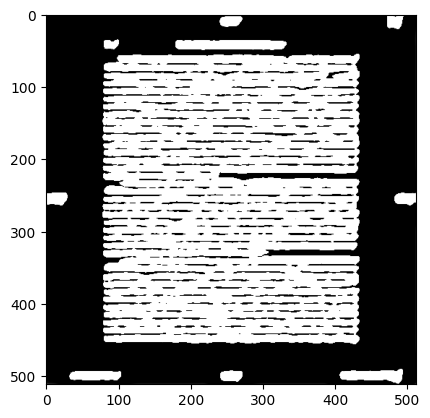

In [51]:
img=np.expand_dims(img,axis=0)
pred=model.predict(img)
pred=np.squeeze(np.squeeze(pred,axis=0),axis=-1)
plt.imshow(pred,cmap='gray')

In [41]:
prediction = np.squeeze(pred)  # Remove extra dimensions (shape: [height, width])
prediction = (prediction * 255).astype(np.uint8)  # Convert to 8-bit image

# Save the output using OpenCV
cv2.imwrite('attention_seg_out.png', prediction)

True